<a href="https://colab.research.google.com/github/roycosmology/BRICS/blob/main/Stellar_Classification_Customized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Data Loading and Exploration

# BRICS ASTRONOMY 2025: CAPSTONE PROJECT

# TITLE: **Machine Learning-Based Classification of Stellar Types Using the Hertzsprung–Russell Diagram**

## **Introduction**

In this work, I utilized stellar data from the [Hipparcos catalog](https://en.wikipedia.org/wiki/Hipparcos), a pioneering space-based astrometry mission, to build a machine learning model for stellar classification. Using fundamental observational features such as Right Ascension (RA), Declination (DEC), parallax (Plx), proper motions (pmRA, pmDEC), color index (B−V), and absolute magnitude (M_V), I trained a supervised learning algorithm to categorize stars into various luminosity classes (e.g., main-sequence, giants, white dwarfs) based on their positions in the Hertzsprung–Russell (HR) diagram.

To obtain the dataset, I accessed the [**VizieR Search Page**](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/239/hip_main) for catalog **I/239** from the **Strasbourg Astronomical Data Center (CDS)**. I selected only the relevant fields: `HIP`, `Vmag`, `Plx`, `BV`, and `SpType`. In the left pane under **"Preferences"**, I set the output to **"unlimited"** and chose **";-Separated Values"** as the format. After clicking the **"Submit"** button, I downloaded the file and saved it as `I_239_selection.tsv`.

After training and validating the model on the Hipparcos data, I applied it to classify stars from the **Gaia Data Release 3 (DR3)**. This enabled automated classification of stellar types using Gaia's large-scale survey data. The project demonstrates the power of combining classical astrophysical principles with modern machine learning techniques to efficiently classify stellar populations across the sky.


## Importing necessary libraries

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Opening the `I_239_selection` file

In [ ]:
# Getting the data file
!wget https://raw.githubusercontent.com/roycosmology/BRICS/main/I_239_selection.tsv

filename = './I_239_selection.tsv'
df = pd.read_table(filename, skiprows=39, sep=';', header=None, index_col=0,
                   names = ['HIP', 'Vmag', 'RA', 'DEC', 'Plx', 'pmRA', 'pmDE', 'B-V', 'SpType'],
                   skipfooter=1, engine='python')

--2025-06-30 01:38:27--  https://raw.githubusercontent.com/roycosmology/BRICS/main/I_239_selection.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9032939 (8.6M) [text/plain]
Saving to: ‘I_239_selection.tsv’

I_239_selection.tsv 100%[===================>]   8.61M  3.31MB/s    in 2.6s    

2025-06-30 01:38:30 (3.31 MB/s) - ‘I_239_selection.tsv’ saved [9032939/9032939]



## Step 2: Feature Engineering

In [ ]:
#=====Printing the first few elements of the dataset======

df.head()

,Vmag,RA,DEC,Plx,pmRA,pmDE,B-V,SpType
HIP,,,,,,,,
1,9.10,000.00091185,+01.08901332,3.54,-5.20,-1.88,0.482,F5
2,9.27,000.00379737,-19.49883745,21.90,181.21,-0.93,0.999,K3V
3,6.61,000.00500795,+38.85928608,2.81,5.24,-2.91,-0.019,B9
4,8.06,000.00838170,-51.89354612,7.75,62.85,0.16,0.370,F0V
5,8.55,000.00996534,-40.59122440,2.87,2.53,9.07,0.902,G8III


#### Before we start working with the data, we will first analyze whether there are entries in the catalog without valid data (eg with NaN values​​)

In [ ]:
df.describe()

,Vmag,RA,DEC,Plx,pmRA,pmDE,B-V,SpType
count,118218,118218,118218,118218,118218,118218,118218,115184
unique,1127,117956,117956,5617,24497,22128,2437,4124
top,8.69,,,,,,,K0
freq,504,263,263,263,263,263,1281,8570


#### The "count" value indicates that in some of the 118322 entries in the catalog there are missing values, and it happens in each of the six columns. They are marked in the dataframe as nonexistent values (NaN). We will identify and eliminate those columns.

#### But before we clean these NaN values, we will change any field with spaces to NaN values, since blank spaces are not considered by Pandas as NaN, but nevertheless should be eliminated, because we can not perform calculations with them

In [ ]:
df_clean = df.apply(lambda row: row.map(lambda x: np.nan if isinstance(x, str) and x.isspace() else x), axis=1)
df_clean= df_clean.dropna()

In [ ]:
df_clean.describe()

,Vmag,RA,DEC,Plx,pmRA,pmDE,B-V,SpType
count,114472,114472,114472,114472,114472,114472,114472,114472
unique,1072,114472,114472,5361,23424,21143,2426,4070
top,8.69,359.97879195,-65.57707774,2.93,-2.49,-1.83,1.000,K0
freq,502,1,1,182,56,52,308,8537


#### Finally, all rows that contain a NaN value will be removed

In [ ]:
df_clean.shape

(114472, 8)

#### It is found that the non-zero counter values now match the number of lines in the dataframe. From now on we will work with the "df_clean" dataframe.

#### Next we are going to calculate, by using the formula below, the absolute magnitude in the V filter, which we will call 'M_V'. I will add a new column to the dataframe, but previously I will change the columns of the dataframe with which we plan to operate, converting them from strings to numeric values.

$$
M_V = V - 5 \log_{10} \left( \frac{d}{10} \right)
$$

##### See [Absolute Magnitude](https://en.wikipedia.org/wiki/Absolute_magnitude) for more details

In [ ]:
# Changing the data type

df_clean['Vmag'] = df_clean['Vmag'].astype(float)
df_clean['Plx'] = df_clean['Plx'].astype(float)
df_clean['B-V'] = df_clean['B-V'].astype(float)

In [ ]:
# Add a new column with the absolute magnitude
df_clean['M_V'] = df_clean['Vmag'] + 5 * np.log10(df_clean['Plx']/100.)

/home/rohan-roy/miniconda3/envs/brics/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rohan-roy/miniconda3/envs/brics/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
df_clean.head()

,Vmag,RA,DEC,Plx,pmRA,pmDE,B-V,SpType,M_V
HIP,,,,,,,,,
1,9.10,000.00091185,+01.08901332,3.54,-5.20,-1.88,0.482,F5,1.845016
2,9.27,000.00379737,-19.49883745,21.90,181.21,-0.93,0.999,K3V,5.972221
3,6.61,000.00500795,+38.85928608,2.81,5.24,-2.91,-0.019,B9,-1.146468
4,8.06,000.00838170,-51.89354612,7.75,62.85,0.16,0.370,F0V,2.506509
5,8.55,000.00996534,-40.59122440,2.87,2.53,9.07,0.902,G8III,0.839409


#### Next let's study the spectral types present in the dataframe. Really the only information needed at this time from the SpType column are the first two characters. Furthermore we will be only interested in those cases where the first character is alphabetic and the second is a number, like G8 or F5. After removing the anomalies, a new column is created with only the first two characters:

In [ ]:
# Rows that do not meet the condition alpha + num are eliminated
f = lambda s: (len(s) >= 2)  and (s[0].isalpha()) and (s[1].isdigit())
i  = df_clean['SpType'].apply(f)
df_clean = df_clean[i]

# A new column is created with the first two characters from 'SpType'
f = lambda s: s[0:2]
df_clean['SpType2'] = df_clean['SpType'].apply(f)

In [ ]:
df_clean.shape

(111562, 10)

In [ ]:
df_clean.head()

,Vmag,RA,DEC,Plx,pmRA,pmDE,B-V,SpType,M_V,SpType2
HIP,,,,,,,,,,
1,9.10,000.00091185,+01.08901332,3.54,-5.20,-1.88,0.482,F5,1.845016,F5
2,9.27,000.00379737,-19.49883745,21.90,181.21,-0.93,0.999,K3V,5.972221,K3
3,6.61,000.00500795,+38.85928608,2.81,5.24,-2.91,-0.019,B9,-1.146468,B9
4,8.06,000.00838170,-51.89354612,7.75,62.85,0.16,0.370,F0V,2.506509,F0
5,8.55,000.00996534,-40.59122440,2.87,2.53,9.07,0.902,G8III,0.839409,G8


#### Let's see what are the spectral classes present in the dataframe

In [ ]:
f = lambda s: s[0]
clases = df_clean['SpType'].map(f)
clases.value_counts()

SpType
K    31578
F    25201
G    22213
A    17651
B    10281
M     4212
O      256
C       82
N       48
R       23
S       17
Name: count, dtype: int64

#### We'll now remove lines with Special Classes C N, R and S to keep only those in the sequence OBAFGKM

In [ ]:
f = lambda s: s[0] in 'OBAFGKM'
df_clean = df_clean[df_clean['SpType'].map(f)]

In [ ]:
f = lambda s: s[0]
clases = df_clean['SpType'].map(f)
clases.value_counts()

SpType
K    31578
F    25201
G    22213
A    17651
B    10281
M     4212
O      256
Name: count, dtype: int64

#### The purpose is to make a graph where on the horizontal axis are the spectral classes included in the Morgan-Keenan system (MKK) "OBAFGKM", followed by a digit 0-9. In addition we want that the spectral classes appear ordered precisely in this order (B5 before A0...). So I'm going to replace the letters by digits in ascending sequence in the SpType2 column, in order to sort by that column.

In [ ]:
orden = {'O':'0', 'B':'1', 'A':'2', 'F':'3', 'G':'4', 'K':'5', 'M':'6'}
f = lambda s: orden[s[0]]+s[1]
df_clean['SpType2'] = df_clean['SpType2'].apply(f)
df_clean.head()

,Vmag,RA,DEC,Plx,pmRA,pmDE,B-V,SpType,M_V,SpType2
HIP,,,,,,,,,,
1,9.10,000.00091185,+01.08901332,3.54,-5.20,-1.88,0.482,F5,1.845016,35
2,9.27,000.00379737,-19.49883745,21.90,181.21,-0.93,0.999,K3V,5.972221,53
3,6.61,000.00500795,+38.85928608,2.81,5.24,-2.91,-0.019,B9,-1.146468,19
4,8.06,000.00838170,-51.89354612,7.75,62.85,0.16,0.370,F0V,2.506509,30
5,8.55,000.00996534,-40.59122440,2.87,2.53,9.07,0.902,G8III,0.839409,48


## Chart Plot

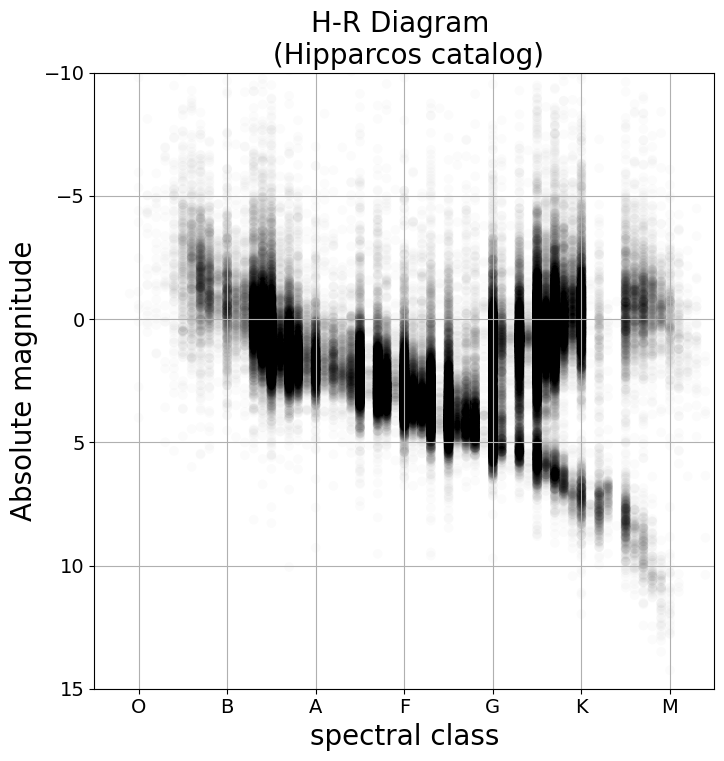

In [ ]:
#====Ploting the HR diagram with spectral line as x data=====

fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim(0, 70)
ax.set_ylim(15, -10)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(20)
ax.set_xlabel('spectral class')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Absolute magnitude')
ax.yaxis.label.set_fontsize(20)

ax.scatter(df_clean['SpType2'].astype(int), df_clean['M_V'],
           s=50, edgecolors='none', alpha=0.015, c='k')
ax.set_xticks(range(5,75,10))
ax.set_xticklabels(['O', 'B', 'A', 'F', 'G', 'K', 'M'])
ax.tick_params(axis='both', labelsize=14)

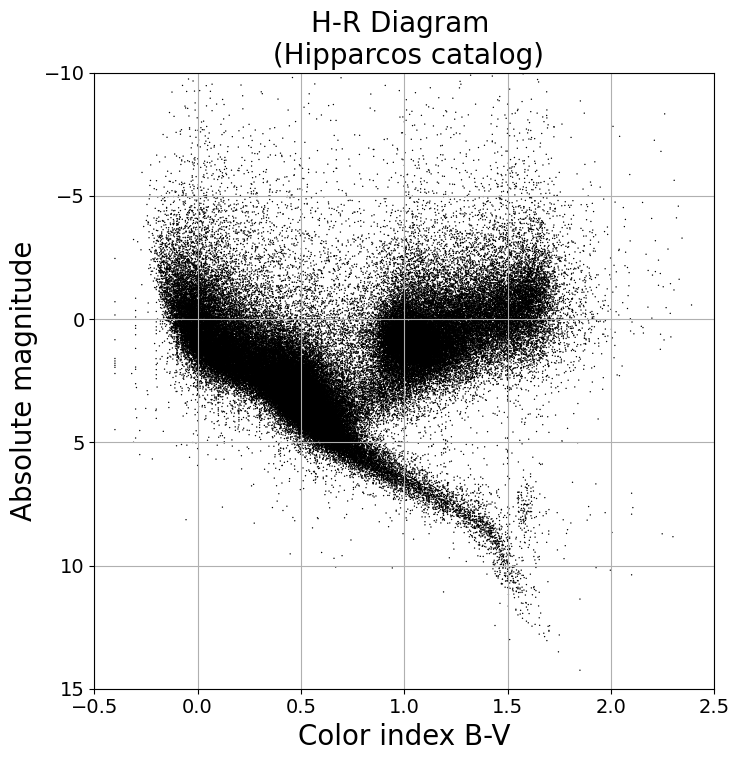

In [ ]:
#=======HR Diagram with color index B-V=======

fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -10)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(20)
ax.set_xlabel('Color index B-V')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Absolute magnitude')
ax.yaxis.label.set_fontsize(20)

ax.scatter(df_clean['B-V'], df_clean['M_V'],
#           s=50, edgecolors='none', alpha=0.015, c='k')
           s=1, edgecolors='none', c='k')

ax.tick_params(axis='both', labelsize=14)

## Maping the spectral type to star catagory

#### Our next task is to map the spectral type with the star catagory.

In [ ]:
#=========Define the classifier function=====

def classify_luminosity(s):
    if isinstance(s, str):
        if 'VII' in s:
            return 'VII: white dwarfs'
        elif 'VI' in s and 'VII' not in s:
            return 'VI: subdwarfs'
        elif 'V' in s and 'VI' not in s and 'IV' not in s:
            return 'V: main-sequence'
        elif 'IV' in s:
            return 'IV: subgiants'
        elif 'III' in s:
            return 'III: giants'
        elif 'II' in s and 'III' not in s and 'VII' not in s:
            return 'II: bright giants'
        elif 'I' in s and 'II' not in s and 'V' not in s:
            return 'I: supergiants'
    return 'Unclassified'


In [ ]:
#========Create the new 'type' column====

df_clean['type'] = df_clean['SpType'].map(classify_luminosity)

In [ ]:
#========Define color map for each class===

class_colors = {
    'VII: white dwarfs': 'white',
    'VI: subdwarfs': 'blue',
    'V: main-sequence': 'black',
    'IV: subgiants': 'grey',
    'III: giants': 'green',
    'II: bright giants': 'orange',
    'I: supergiants': 'yellow'
}

####  So let's analyze the presence of these luminosity classes in the HIPPARCOS catalog:

In [ ]:
#=====Print counts====
for star_class in class_colors:
    count = (df_clean['type'] == star_class).sum()
    print(f"Class {star_class}, there are {count} stars")


Class VII: white dwarfs, there are 1 stars
Class VI: subdwarfs, there are 16 stars
Class V: main-sequence, there are 24683 stars
Class IV: subgiants, there are 7955 stars
Class III: giants, there are 20958 stars
Class II: bright giants, there are 1237 stars
Class I: supergiants, there are 937 stars


#### However, there's yet a significant number of entries in the catalog that do contain information of the stellar class, so it makes sense to show the position of each of these luminosity classes in the H-R diagram

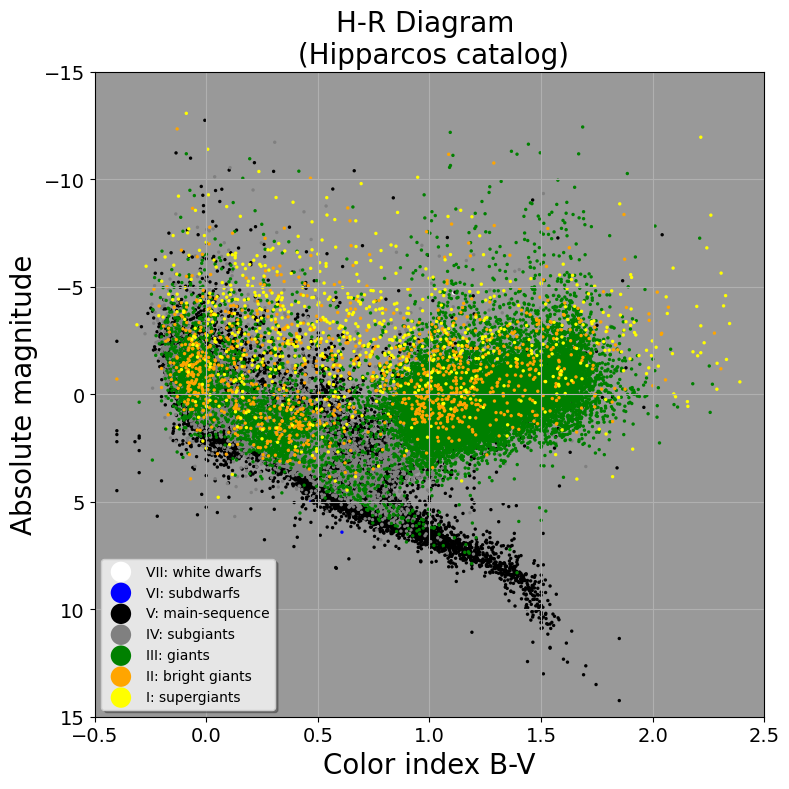

In [ ]:
# Plotting function
def plot_lum_class(b, c, label):
    '''
    b: boolean Series to make the selection
    c: color for points
    label: for the legend
    '''
    x = df_clean.loc[b, 'B-V']
    y = df_clean.loc[b, 'M_V']
    ax.scatter(x, y, c=c, s=6, edgecolors='none', label=label)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('0.6')

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -15)
ax.grid(True)

ax.set_title('H-R Diagram \n (Hipparcos catalog)', fontsize=20)
ax.set_xlabel('Color index B-V', fontsize=20)
ax.set_ylabel('Absolute magnitude', fontsize=20)
ax.tick_params(axis='both', labelsize=14)

# Plot each stellar class from the 'type' column
for star_type, color in class_colors.items():
    b = df_clean['type'] == star_type
    plot_lum_class(b, color, star_type)

# Add legend
legend = ax.legend(scatterpoints=1, markerscale=6, shadow=True)
legend.get_frame().set_facecolor('0.90')

plt.tight_layout()

plt.show()

## Using Machine Learning

#### Now that we have created a data frame containg various features `(RA, DEC, Plx, pmRA, pmDE, M_V)` and the corresponding labels `(type)`. Our next task is to create a machine learning model to study the star type given the features. In this project, I have used Random Forest Classifier to make the model.

#### Bofore gettting into the modeling part, lets look at our data frame one again

In [ ]:
df_clean.head()

,Vmag,RA,DEC,Plx,pmRA,pmDE,B-V,SpType,M_V,SpType2,type
HIP,,,,,,,,,,,
1,9.10,000.00091185,+01.08901332,3.54,-5.20,-1.88,0.482,F5,1.845016,35,Unclassified
2,9.27,000.00379737,-19.49883745,21.90,181.21,-0.93,0.999,K3V,5.972221,53,V: main-sequence
3,6.61,000.00500795,+38.85928608,2.81,5.24,-2.91,-0.019,B9,-1.146468,19,Unclassified
4,8.06,000.00838170,-51.89354612,7.75,62.85,0.16,0.370,F0V,2.506509,30,V: main-sequence
5,8.55,000.00996534,-40.59122440,2.87,2.53,9.07,0.902,G8III,0.839409,48,III: giants


#### Now, our first task is to split the data into training set and testing set. But before that we will remove the invalid data, which contains non numeric values:

In [ ]:
# Step 1: Select features and label
features = ['RA', 'DEC', 'Plx', 'pmRA', 'pmDE', 'B-V', 'M_V']
label = 'type'

# Step 2: Drop rows with missing values in selected columns
df_ml = df_clean.dropna(subset=features + [label])

# Step 3: Create X and y
X = df_ml[features]
y = df_ml[label]

X = X.replace([np.inf, -np.inf], np.nan)   # Convert inf → NaN
X = X.dropna()                             # Drop rows with any NaN

# Step 4: Align y accordingly
y = y.loc[X.index]

# Step 4: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### Now that the training and test set is ready, next we find the best parameter to be used in the `RandomForestClassifier` and for that we use `GridSearchCV` and obtain the best parameter

In [ ]:
#Step 1: Define the parameter matrix
param_grid = {
    'n_estimators': [80, 90, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
#Step 2: Evalute the best parameter fit

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

#Step 3: Fit the training set to train the model
grid_search.fit(X_train_scaled, y_train)

#Step 4:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.3f}")

# Note: Best to run in local machine---Taking more time on googlecolab

/home/rohan-roy/miniconda3/envs/brics/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best CV accuracy: 0.797


#### After fitting the data we get our model as:

In [ ]:
# Best model
clf = grid_search.best_estimator_
clf

RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       random_state=42)

#### Next we try to validate our model using the test data set and obtain the classifiaction report and hence plot the confusion matrix.

In [ ]:
#=======Finding the predection and obtaining the precision report=========
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))

                   precision    recall  f1-score   support

   I: supergiants       0.51      0.34      0.41       235
II: bright giants       0.32      0.05      0.09       344
      III: giants       0.81      0.77      0.79      6075
    IV: subgiants       0.38      0.15      0.21      2353
     Unclassified       0.87      0.93      0.90     16083
 V: main-sequence       0.70      0.81      0.75      7293
    VI: subdwarfs       0.00      0.00      0.00         5

         accuracy                           0.80     32388
        macro avg       0.51      0.44      0.45     32388
     weighted avg       0.78      0.80      0.78     32388



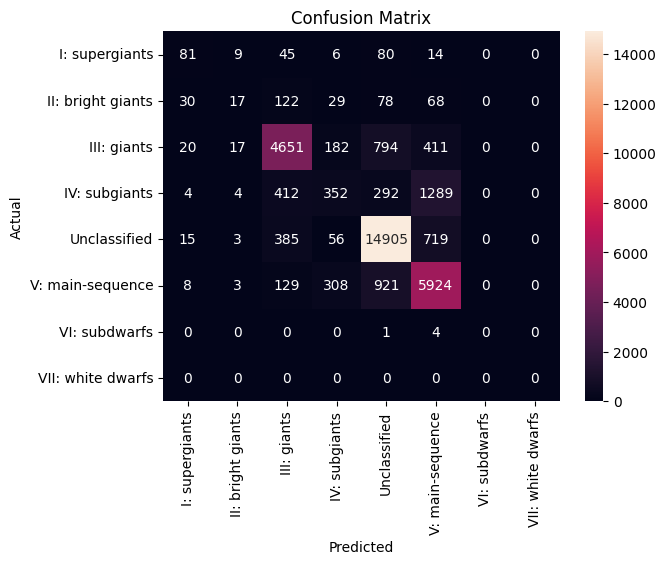

In [ ]:
# Plotting the confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#### As we can see that many data are wongly predected. This happens because of lack of data for that particular type.

#### Now finally we will save our model as `star_classifier_model.pkl`

In [ ]:
import joblib

# Save model
joblib.dump(clf, 'star_classifier_model.pkl')


['star_classifier_model.pkl']

## Application of the Model on Gaia DR3

#### Now that we have trained our model our next task is to use this model on Gaia dataset

#### Our first job is to import the datase

In [ ]:
#======Importing the astropy module to obtain the Gaia data set
from astroquery.gaia import Gaia

query = '''
SELECT TOP 20000
source_id, ra, dec, parallax, pmra, pmdec,
phot_g_mean_mag, bp_rp
FROM gaiadr3.gaia_source
WHERE parallax > 1 AND phot_g_mean_mag < 18 AND bp_rp IS NOT NULL
'''
job = Gaia.launch_job_async(query)
gaia = job.get_results().to_pandas()
gaia.head()

INFO: Query finished. [astroquery.utils.tap.core]


,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp
0,418551920284673408,10.127242,56.537189,14.090976,49.125646,-31.595374,1.942524,1.143484
1,4357027756659697664,243.586211,-3.694968,20.411292,-45.340019,-144.432722,2.016425,1.563310
2,5589311357728452608,109.285594,-37.097444,5.762063,-11.562000,6.520111,2.083237,1.542580
3,4993479684438433792,6.572156,-42.307820,39.918258,176.268293,-398.872135,2.089978,1.269482
4,4038055447778237312,274.406090,-36.762429,23.885852,-131.804070,-166.308930,2.116495,1.827267


#### We have opened the gaia data set containing the top 20000 data, with the features as `ra`, `dec`, `parallax`, `pmra`, `pmdec`, `bp_rp`

#### Next we clean the data by removing non-number data

In [ ]:
gaia = gaia.dropna()
gaia = gaia[gaia['parallax'] > 0]

#### Our next job is to calculate the absolute magnitude and add that to the dataset. We aslo change the coloum name to that we have used to train our model.

In [ ]:
# Compute absolute magnitude
gaia['abs_mag'] = gaia['phot_g_mean_mag'] + 5 * (np.log10(gaia['parallax'] / 1000) + 1)

# Changing the column name
gaia.rename(columns={'ra': 'RA', 'dec': 'DEC', 'parallax': 'Plx', 'pmra': 'pmRA', 'pmdec': 'pmDE', 'bp_rp': 'B-V', 'abs_mag': 'M_V'}, inplace=True)

gaia.head()

,source_id,RA,DEC,Plx,pmRA,pmDE,phot_g_mean_mag,B-V,M_V
0,418551920284673408,10.127242,56.537189,14.090976,49.125646,-31.595374,1.942524,1.143484,-2.312771
1,4357027756659697664,243.586211,-3.694968,20.411292,-45.340019,-144.432722,2.016425,1.563310,-1.434222
2,5589311357728452608,109.285594,-37.097444,5.762063,-11.562000,6.520111,2.083237,1.542580,-4.113873
3,4993479684438433792,6.572156,-42.307820,39.918258,176.268293,-398.872135,2.089978,1.269482,0.095835
4,4038055447778237312,274.406090,-36.762429,23.885852,-131.804070,-166.308930,2.116495,1.827267,-0.992801


#### We plot the HR diagram for the Gaia Data set

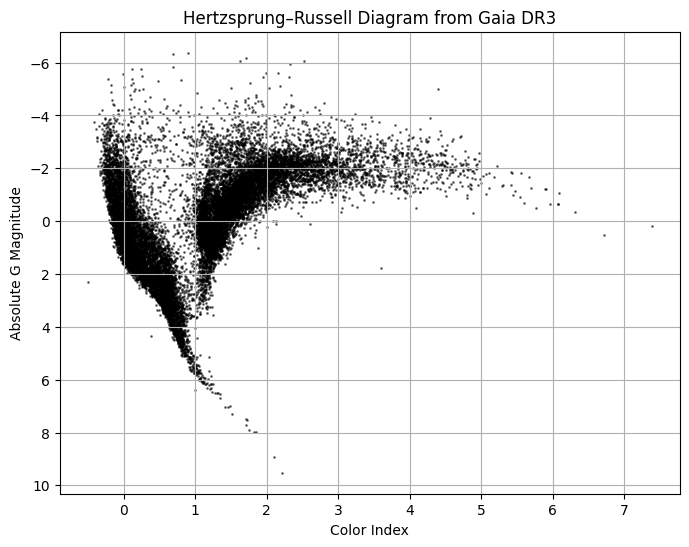

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(gaia['B-V'], gaia['M_V'], s=1, alpha=0.5, c='black')
plt.gca().invert_yaxis()
plt.xlabel("Color Index")
plt.ylabel("Absolute G Magnitude")
plt.title("Hertzsprung–Russell Diagram from Gaia DR3")
plt.grid(True)
plt.show()


#### Next task is to create the feature set `(X_scaled)` with standarized values.

In [ ]:
features = ['RA', 'DEC', 'Plx', 'pmRA', 'pmDE', 'B-V', 'M_V']
X = gaia[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Now, we load our `RandomForestClassifier` model and do the prediction fot the `Gaia` data set

In [ ]:
rf = joblib.load('star_classifier_model.pkl')
rf

RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       random_state=42)

In [ ]:
#  Predicting the star type using the ML model
y_pred = clf.predict(X_scaled)

# Adding the types to the dataset
gaia['Type'] = y_pred

# Printing the first few elements of the Gaia data set
gaia.head()

,source_id,RA,DEC,Plx,pmRA,pmDE,phot_g_mean_mag,B-V,M_V,Type
0,418551920284673408,10.127242,56.537189,14.090976,49.125646,-31.595374,1.942524,1.143484,-2.312771,III: giants
1,4357027756659697664,243.586211,-3.694968,20.411292,-45.340019,-144.432722,2.016425,1.563310,-1.434222,III: giants
2,5589311357728452608,109.285594,-37.097444,5.762063,-11.562000,6.520111,2.083237,1.542580,-4.113873,III: giants
3,4993479684438433792,6.572156,-42.307820,39.918258,176.268293,-398.872135,2.089978,1.269482,0.095835,IV: subgiants
4,4038055447778237312,274.406090,-36.762429,23.885852,-131.804070,-166.308930,2.116495,1.827267,-0.992801,III: giants


#### Now that we get the classification of stars, we plotted the result with different catagory of stars colored diferent.

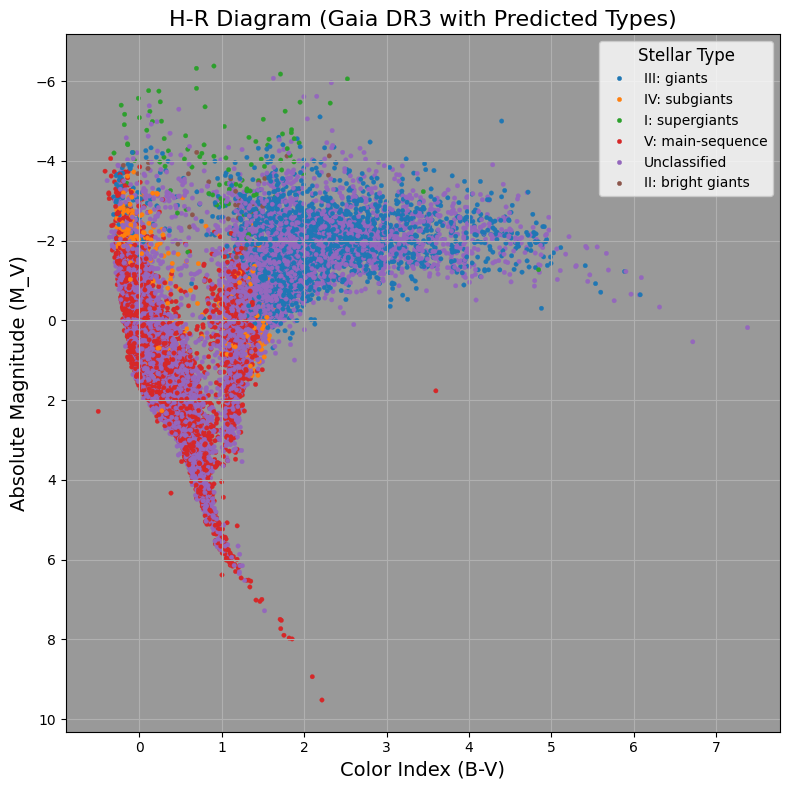

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Setting style
ax.set_facecolor('0.6')

sns.scatterplot(
    data=gaia,
    x='B-V',
    y='M_V',
    hue='Type',
    palette='tab10',
    s=10,
    edgecolor=None,
    ax=ax
)

# Invert y-axis (bright stars are at the top)
plt.ylim(plt.ylim()[::-1])
plt.grid()
# Labels and title
plt.title("H-R Diagram (Gaia DR3 with Predicted Types)", fontsize=16)
plt.xlabel("Color Index (B-V)", fontsize=14)
plt.ylabel("Absolute Magnitude (M_V)", fontsize=14)
plt.legend(title='Stellar Type', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()


#### We did another plotting, in which the unclassified catagory is removed

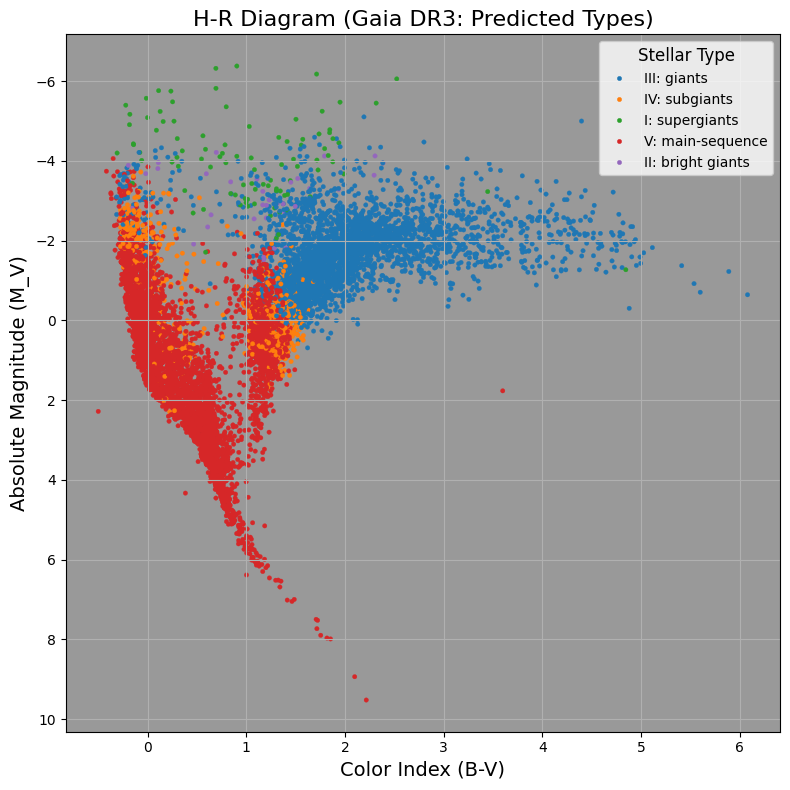

In [ ]:

# Filter out 'Unclassified' entries
filtered_df = gaia[gaia['Type'] != 'Unclassified']

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('0.6')

# Plot using seaborn
sns.scatterplot(
    data=filtered_df,
    x='B-V',
    y='M_V',
    hue='Type',
    palette='tab10',
    s=10,
    edgecolor=None,
    ax=ax
)

# Invert y-axis for HR diagram
ax.set_ylim(ax.get_ylim()[::-1])

# Labels and title
ax.set_title("H-R Diagram (Gaia DR3: Predicted Types)", fontsize=16)
ax.set_xlabel("Color Index (B-V)", fontsize=14)
ax.set_ylabel("Absolute Magnitude (M_V)", fontsize=14)
ax.legend(title='Stellar Type', fontsize=10, title_fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()


## Conclusion

#### From the Hertzsprung–Russell (HR) diagram generated using Gaia DR3 data and the trained machine learning model, we observe that a significant number of stars remain classified as **"Unclassified."** This outcome primarily arises due to the **imbalance in the training dataset**—certain stellar categories such as **main-sequence, giants, and subgiants** are represented by a much larger number of samples compared to rarer types like white dwarfs or supergiants.

#### As a result, the model becomes biased toward the overrepresented classes, reducing its ability to accurately classify underrepresented stellar types. **This project does not include any explicit class balancing techniques**, such as resampling or class weighting, which could help mitigate this issue.

#### To improve classification performance in future work, it would be beneficial to incorporate a more balanced dataset or apply methods like **class weighting**, **data augmentation**, or **ensemble learning** to reduce bias and enhance model generalization across all stellar categories.
